## Imports Necessários

In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_rows', None)


In [22]:
df = pd.read_csv('C:\\Users\\marce\\OneDrive\\Dokumenti\\GitHub\\psValcann\\Valcann-Ps\\data\\vendas_produto_alfa.csv')

In [23]:
df.head()

,data,vendas,dia_da_semana,em_promocao,feriado_nacional
0,2025-08-08 22:01:44.459032,139.0,sexta-feira,False,False
1,2025-07-04 22:01:44.459032,133.0,sexta-feira,True,True
2,2024-12-25 22:01:44.459032,579.0,quarta-feira,True,False
3,2025-04-14 22:01:44.459032,105.0,segunda-feira,False,False
4,2026-03-25 22:01:44.459032,60.0,quarta-feira,True,False


## Exploratory Data Analysis

In [24]:
df.shape

(1015, 5)

In [25]:
df.dtypes

data                 object
vendas              float64
dia_da_semana        object
em_promocao          object
feriado_nacional     object
dtype: object

In [29]:
df.isnull().sum()

data                 0
vendas               0
dia_da_semana       30
em_promocao         20
feriado_nacional     0
dtype: int64

### NULL Values

In [26]:
# Data
df = df.loc[~df['data'].isna()]

In [27]:
df['data'] = pd.to_datetime(df['data'])

In [28]:
# Vendas
df['vendas'] = df['vendas'].fillna(
    df.groupby('dia_da_semana')['vendas'].transform('mean')
)

In [11]:
# Dia da Semana

dias_semana = {
    0: 'segunda-feira',
    1: 'terca-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sabado',
    6: 'domingo'
}

def preencher_dia_da_semana(row):
    if pd.isna(row['dia_da_semana']):
        return dias_semana[row['data'].weekday()]
    else:
        return row['dia_da_semana']

df['dia_da_semana'] = df.apply(preencher_dia_da_semana, axis=1)


In [12]:
# Em Promoção
probs = df['em_promocao'].value_counts(normalize=True)

# Função para imputar nulos
def imputar_em_promocao(val):
    if pd.isna(val):
        return np.random.choice([True, False], p=[probs[True], probs[False]])
    else:
        return val

df['em_promocao'] = df['em_promocao'].apply(imputar_em_promocao)


### Transformation

In [13]:
# Vendas -> INT
df['vendas'] = df['vendas'].astype(int)

# Em Promocao -> False 0 | True 1
df['em_promocao'] = df['em_promocao'].astype(int)

# Feriado Nacional -> False 0 | True 1
df['feriado_nacional'] = df['feriado_nacional'].astype(int)

# Dias da Semana
dias_semana = {
    'segunda-feira': 0,
    'terca-feira': 1,
    'quarta-feira': 2,
    'quinta-feira': 3,
    'sexta-feira': 4,
    'sabado': 5,
    'domingo': 6
}

def transformar_dias(col):
    return col.map(dias_semana)

df['dia_da_semana'] = transformar_dias(df['dia_da_semana'])

df['dia_da_semana'] = df['dia_da_semana'].astype(int)


### Univariate Analysis

In [14]:
df['vendas'].describe()

count    1005.000000
mean      129.419900
std        62.366757
min       -66.000000
25%        90.000000
50%       130.000000
75%       164.000000
max       873.000000
Name: vendas, dtype: float64

#### Histograma

<Axes: xlabel='vendas', ylabel='Count'>

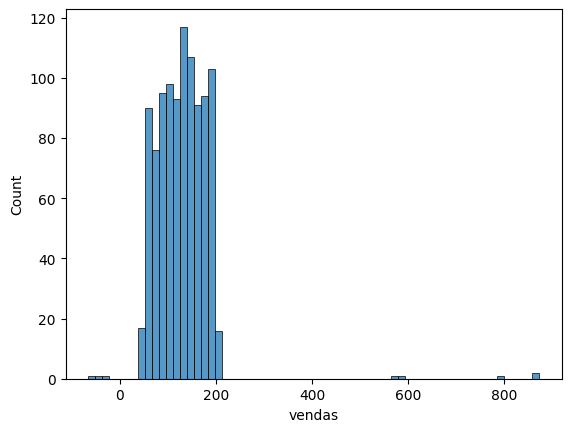

In [15]:
sns.histplot(data=df, x="vendas")

#### Boxplot

<Axes: xlabel='vendas'>

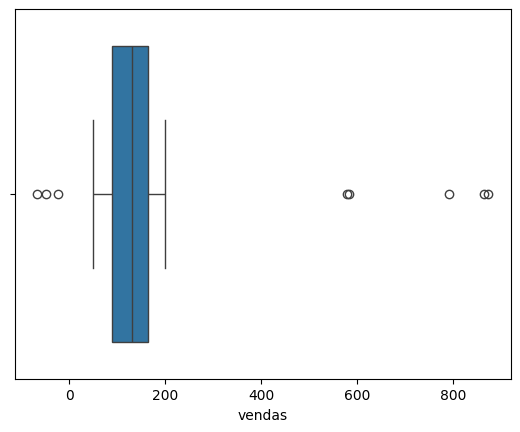

In [16]:
sns.boxplot(data=df, x="vendas")

### Multivariate Analysis

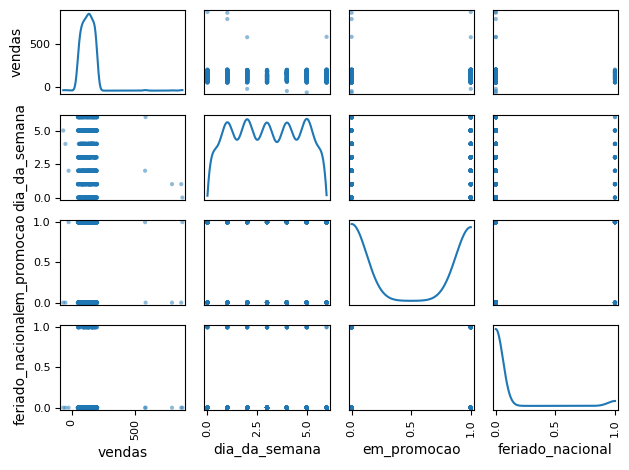

In [17]:
scatter_matrix(df, diagonal="kde")
plt.tight_layout()
plt.show()


## Pre Processing / Normalization

In [18]:
df.drop_duplicates(inplace=True)

## Feature Engineering

In [19]:
# Mês
df['Mês'] = df['data'].dt.month

# Final de Semana
df['Fds'] = (df['dia_da_semana'] >= 5).astype(int)

# Dia de Semana
df['Dia de Semana'] = (df['dia_da_semana'] <= 4).astype(int)

In [20]:
df.isna().sum()

data                0
vendas              0
dia_da_semana       0
em_promocao         0
feriado_nacional    0
Mês                 0
Fds                 0
Dia de Semana       0
dtype: int64

## Linear Regression

#### Um treinamento muito rápido me indica que usando um algoritmo de regressao linear, eu tenho um erro quadrado médio menor que o xgboost, então vamos optar por usar ele mesmo. Os próximos passo é passar por outro ciclo do crispy dm buscando aumentar a acurácia do nosso modelo

In [21]:
df.columns

Index(['data', 'vendas', 'dia_da_semana', 'em_promocao', 'feriado_nacional',
       'Mês', 'Fds', 'Dia de Semana'],
      dtype='object')